In [103]:
import sys
sys.path.insert(0, '../../../fastshap_tf/')
from fastshap import ResizeMask

In [41]:
import pickle
import numpy as np

In [42]:
import tensorflow as tf
import tensorflow_datasets as tfds

from datetime import datetime
import os

In [43]:
from tensorflow.keras.layers import (Input, Layer, Dense, Lambda, 
                                     Dropout, Multiply, BatchNormalization, 
                                     Reshape, Concatenate, Conv2D, Permute)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications.resnet50 import ResNet50

In [44]:
import pandas as pd
from functools import reduce

In [45]:
#Select GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [119]:
# IMPORTANT: SET RANDOM SEEDS FOR REPRODUCIBILITY
os.environ['PYTHONHASHSEED'] = str(420)
import random
random.seed(420)
np.random.seed(420)

In [46]:
#################### Load Images + Predictions ####################
images_dir = os.path.join('../', 'images')
images = np.load(os.path.join(images_dir, 'processed_images.npy'), allow_pickle=True)


preds_path = os.path.join(images_dir, 'predictions.npy')
preds = np.load(preds_path, allow_pickle=True)
preds_discrete = np.eye(10)[preds.argmax(1)]

In [47]:
#################### Load Evaluator Model ####################
class Random_Bernoulli_Sampler(Layer):
    '''
    Layer to Sample r
    '''
    def __init__(self, num_features, **kwargs):
        super(Random_Bernoulli_Sampler, self).__init__(**kwargs)
        
        self.num_features = num_features
        
        
    def call(self,  logits):
        batch_size = tf.shape(logits)[0]
        
        u = tf.random.uniform(shape=(batch_size, self.num_features),
                                    minval=np.finfo(
                                        tf.float32.as_numpy_dtype).tiny,
                                    maxval=1.0) 

        r = K.cast(tf.stop_gradient(u > 0.5), tf.float32)
        
        return r

    
INPUT_SHAPE = (224,224,3)
base_model = ResNet50(
    include_top=False, weights='imagenet', 
    input_shape=INPUT_SHAPE, pooling='avg'
)
base_model.trainable = True

model_input = Input(shape=INPUT_SHAPE, dtype='float32', name='input')
R = Random_Bernoulli_Sampler(14*14)(model_input)
R = ResizeMask(in_shape=INPUT_SHAPE, mask_size=14*14)(R)
xr = Multiply()([model_input, R])

net = base_model(xr)
out = Dense(10, activation='softmax')(net)

evaluator_model = Model(model_input, out)

evaluator_weights = 'evaluator/model_weights.h5'
evaluator_model.load_weights(evaluator_weights)
evaluator_model = Sequential(   
            [l for l in evaluator_model.layers[-2:]]
        )
evaluator_model.trainable = False

OPTIMIZER = tf.keras.optimizers.Adam(1e-3)
METRICS = [ 
  tf.keras.metrics.AUC(name='auroc'),
  tf.keras.metrics.AUC(curve='PR', name='auprc'),
  tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='accuracy'),
]

evaluator_model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=METRICS,
)

# Run Evaluations for Each Method and Masking Percent

In [104]:
methods = ['fastshap', 'kernelshap', 'kernelshap_plus', 'gradcam', 'integratedgradients', 'smoothgrad', 'deepshap']
# for method in methods:
for method in ['gradcam', 'integratedgradients', 'smoothgrad', 'deepshap']:
    print(method)
    evaluation_results = {}
    
    #################### Load Masks ####################
    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'masks.pkl'), 'rb') as f:
        mask_dict = pickle.load(f)
    
    evaluation_results['acc'] = {}
    evaluation_results['auroc'] = {}
    evaluation_results['auprc'] = {}
    evaluation_results['preds'] = {}    
    for p, masks in mask_dict.items():
        #################### Mask Images ####################
        if len(masks.shape) < 4:
            masks = np.expand_dims(masks, -1)
        masked_images = images * masks

        #################### Evaluate Masked Images ####################
        _, auroc, auprc, acc = evaluator_model.evaluate(x = masked_images, 
                                                        y = preds_discrete)
        preds = evaluator_model.predict(masked_images)
        
        evaluation_results['acc'][p] = acc
        evaluation_results['auroc'][p] = auroc
        evaluation_results['auprc'][p] = auprc
        evaluation_results['preds'][p] = preds
    
    #################### Save ####################
    with open(os.path.join(method_dir, 'evaluation_results_out.pkl'), 'wb') as f:
        pickle.dump(evaluation_results, f)

gradcam
32/32 [==============================] - 1s 35ms/step - loss: 4.4006 - auroc: 0.5205 - auprc: 0.1140 - accuracy: 0.0960
integratedgradients
32/32 [==============================] - 1s 35ms/step - loss: 4.1281 - auroc: 0.5357 - auprc: 0.1194 - accuracy: 0.1050
smoothgrad
32/32 [==============================] - 1s 36ms/step - loss: 4.0904 - auroc: 0.5327 - auprc: 0.1169 - accuracy: 0.1130
deepshap
32/32 [==============================] - 1s 37ms/step - loss: 4.1097 - auroc: 0.5324 - auprc: 0.1114 - accuracy: 0.1020


In [105]:
methods = ['fastshap', 'kernelshap', 'kernelshap_plus', 'gradcam', 'integratedgradients', 'smoothgrad', 'deepshap']
# for method in methods:
for method in ['gradcam', 'integratedgradients', 'smoothgrad', 'deepshap']:
    print(method)
    evaluation_results = {}
    
    #################### Load Masks ####################
    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'masks_in.pkl'), 'rb') as f:
        mask_dict = pickle.load(f)
    
    evaluation_results['acc'] = {}
    evaluation_results['auroc'] = {}
    evaluation_results['auprc'] = {}
    evaluation_results['preds'] = {}   
    for p, masks in mask_dict.items():
        #################### Mask Images ####################
        if len(masks.shape) < 4:
            masks = np.expand_dims(masks, -1)
        masked_images = images * masks

        #################### Evaluate Masked Images ####################
        _, auroc, auprc, acc = evaluator_model.evaluate(x = masked_images, 
                                                        y = preds_discrete)
        preds = evaluator_model.predict(masked_images)
        
        evaluation_results['acc'][p] = acc
        evaluation_results['auroc'][p] = auroc
        evaluation_results['auprc'][p] = auprc
        evaluation_results['preds'][p] = preds
    
    #################### Save ####################
    with open(os.path.join(method_dir, 'evaluation_results_in.pkl'), 'wb') as f:
        pickle.dump(evaluation_results, f)

gradcam
32/32 [==============================] - 1s 36ms/step - loss: 1.0235 - auroc: 0.9547 - auprc: 0.8700 - accuracy: 0.8220
integratedgradients
32/32 [==============================] - 1s 37ms/step - loss: 1.0292 - auroc: 0.9556 - auprc: 0.8708 - accuracy: 0.8240
smoothgrad
32/32 [==============================] - 1s 35ms/step - loss: 1.0263 - auroc: 0.9551 - auprc: 0.8703 - accuracy: 0.8220
deepshap
32/32 [==============================] - 1s 38ms/step - loss: 1.0283 - auroc: 0.9541 - auprc: 0.8683 - accuracy: 0.8220


# Graph Degradation

In [120]:
results_dir = 'results'
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

### Load Results

In [121]:
methods = ['fastshap', 'kernelshap', 'kernelshap_plus', 'gradcam', 'integratedgradients', 'smoothgrad', 'deepshap']
all_results_out = {}
for method in methods:

    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'evaluation_results_out.pkl'), 'rb') as f:
        evaluation_results = pickle.load(f)
    
    all_results_out[method] = evaluation_results

In [122]:
all_results_in = {}
for method in methods:

    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'evaluation_results_in.pkl'), 'rb') as f:
        evaluation_results = pickle.load(f)
    
    all_results_in[method] = evaluation_results

### Get Bootstrap Accuracys

In [123]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm 

#Initialize Dictionary
for method in methods:
    all_results_out[method]['bootstrap_acc'] = {}
    for p in all_results_out[method]['preds'].keys():
        all_results_out[method]['bootstrap_acc'][p] = []

for i in tqdm(range(100)):
    # Get Bootstrap Indices
    inds = np.random.choice(np.arange(1000), 666, replace=False)
    
    for method in methods:
        for p in all_results_out[method]['preds'].keys():
            # Prediction
            y_p = all_results_out[method]['preds'][p][inds]
            y_p = np.eye(10)[y_p.argmax(1)]
            #Label
            y = preds_discrete[inds]
            #Acc
            acc = accuracy_score(y, y_p)
            #Add to Dict
            all_results_out[method]['bootstrap_acc'][p].append(acc)       

  0%|          | 0/100 [00:00<?, ?it/s]

In [124]:
#Initialize Dictionary
for method in methods:
    all_results_in[method]['bootstrap_acc'] = {}
    for p in all_results_in[method]['preds'].keys():
        all_results_in[method]['bootstrap_acc'][p] = []

for i in tqdm(range(100)):
    # Get Bootstrap Indices
    inds = np.random.choice(np.arange(1000), 666, replace=False)
    
    for method in methods:
        for p in all_results_in[method]['preds'].keys():
            # Prediction
            y_p = all_results_in[method]['preds'][p][inds]
            y_p = np.eye(10)[y_p.argmax(1)]
            #Label
            y = preds_discrete[inds]
            #Acc
            acc = accuracy_score(y, y_p)
            #Add to Dict
            all_results_in[method]['bootstrap_acc'][p].append(acc)

  0%|          | 0/100 [00:00<?, ?it/s]

### Graph

In [125]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# plt.style.use('clean.mplstyle')

In [126]:
def acc_error(x):
    return (x*(1-x)/len(images))**.5

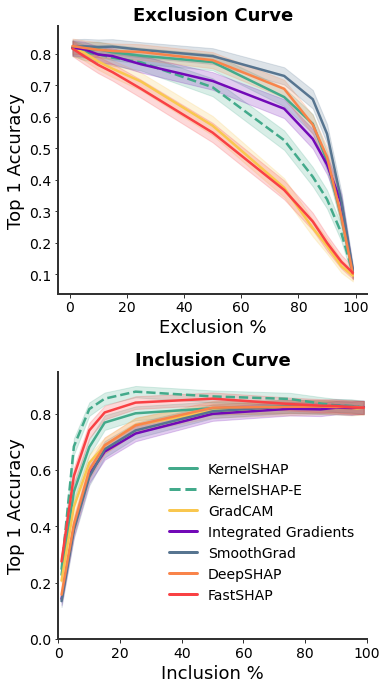

In [135]:
method_names = ['FastSHAP', 'KernelSHAP', 'KernelSHAP-E', 'GradCAM', 'Integrated Gradients', 'SmoothGrad', 'DeepSHAP']
accuracy_out = []
for method in methods:
    df =  pd.DataFrame([(int(k), v) for k, v in all_results_out[method]['acc'].items()])
    df.columns = ['Exclusion %', method]
    accuracy_out.append(df)

accuracy_out = reduce(lambda x, y: pd.merge(x, y, on = 'Exclusion %'), accuracy_out)
accuracy_out.columns = ['Exclusion %'] + method_names

#### FIGURE #####
colors = {'FastSHAP':'#f94144', 'KernelSHAP':'#43aa8b', 'KernelSHAP-E':'#43aa8b', 
          'GradCAM':'#f9c74f', 'Integrated Gradients':'#7209b7', 
          'SmoothGrad':'#577590', 'DeepSHAP':'#f9844a'}

fig, axs = plt.subplots(2, 1, figsize=(7*.8, 14*.7))
for method in method_names[1:] + ['FastSHAP']:
    if method == 'KernelSHAP-E':
        axs[0].plot(accuracy_out['Exclusion %'], accuracy_out[method],
                 label=method, color=colors[method], linestyle='--')
    else:
        axs[0].plot(accuracy_out['Exclusion %'], accuracy_out[method],
                 label=method, color=colors[method])
    axs[0].fill_between(accuracy_out['Exclusion %'],
                     accuracy_out[method] - 1.96*acc_error(accuracy_out[method]),
                     accuracy_out[method] + 1.96*acc_error(accuracy_out[method]),
                     color=colors[method], alpha=0.2)
axs[0].set_xlabel('Exclusion %')
axs[0].set_ylabel('Top 1 Accuracy')
axs[0].set_title('Exclusion Curve')


accuracy_in = []
for method in methods:
    df =  pd.DataFrame([(int(k), v) for k, v in all_results_in[method]['acc'].items()])
    df.columns = ['Inclusion %', method]
    accuracy_in.append(df)

accuracy_in = reduce(lambda x, y: pd.merge(x, y, on = 'Inclusion %'), accuracy_in)
accuracy_in.columns = ['Inclusion %'] + method_names

for method in method_names[1:] + ['FastSHAP']:
    if method == 'KernelSHAP-E':
        axs[1].plot(accuracy_in['Inclusion %'], accuracy_in[method],
                 label=method, color=colors[method], linestyle='--')
    else:
        axs[1].plot(accuracy_in['Inclusion %'], accuracy_in[method],
                 label=method, color=colors[method])
    axs[1].fill_between(accuracy_in['Inclusion %'],
                     accuracy_in[method] - 1.96*acc_error(accuracy_in[method]),
                     accuracy_in[method] + 1.96*acc_error(accuracy_in[method]),
                     color=colors[method], alpha=0.2)

axs[1].set_xlabel('Inclusion %')
axs[1].set_ylabel('Top 1 Accuracy')
axs[1].set_title('Inclusion Curve')

leg = axs[1].legend(loc='right',
                      bbox_to_anchor=(1, 0.4),
                      fancybox=False,
                      shadow=False,
                      ncol=1,
                      fontsize=14,
                      frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)


plt.ylim(0, .95)
plt.xlim(0, 100)
plt.tick_params(labelsize=14)
plt.tight_layout()

pdf = PdfPages(os.path.join(results_dir, 'inclusion.pdf'))
pdf.savefig(pad_inches=0, bbox_inches='tight')
pdf.close()

plt.show()

### AUCs

In [134]:
for method, name in zip(methods, method_names):
    # Exlcusion
    auc_outs = []
    for i in range(100):
        x = []
        y = []
        for p in all_results_out[method]['bootstrap_acc'].keys():
            x.append(float(p))
            y.append(all_results_out[method]['bootstrap_acc'][p][i])
        auc_outs.append(auc(np.array(x), np.array(y)))
    auc_outs = np.array(auc_outs)/100
    
    # Inclusion
    auc_ins = []
    for i in range(100):
        x = []
        y = []
        for p in all_results_in[method]['bootstrap_acc'].keys():
            x.append(float(p))
            y.append(all_results_in[method]['bootstrap_acc'][p][i])
        auc_ins.append(auc(np.array(x), np.array(y)))
    auc_ins = np.array(auc_ins)/100
    
    # Print
    print('{} & {:.2f} ({:.2f}, {:.2f}) & {:.2f} ({:.2f}, {:.2f})'.format(name, 
                                                                        auc_outs.mean(), 
                                                                        np.percentile(auc_outs, 2.5), 
                                                                        np.percentile(auc_outs, 97.5), 
                                                                        auc_ins.mean(), 
                                                                        np.percentile(auc_ins, 2.5), 
                                                                        np.percentile(auc_ins, 97.5)))

FastSHAP & 0.51 (0.49, 0.52) & 0.79 (0.78, 0.80)
KernelSHAP & 0.68 (0.67, 0.70) & 0.77 (0.75, 0.78)
KernelSHAP-S & 0.61 (0.60, 0.62) & 0.82 (0.80, 0.83)
GradCAM & 0.52 (0.50, 0.53) & 0.74 (0.73, 0.76)
Integrated Gradients & 0.65 (0.64, 0.67) & 0.73 (0.71, 0.74)
SmoothGrad & 0.72 (0.71, 0.73) & 0.73 (0.72, 0.75)
DeepSHAP & 0.69 (0.68, 0.71) & 0.74 (0.73, 0.75)


# Runtimes

### Explaining

In [131]:
methods = ['fastshap', 'kernelshap', 'kernelshap_plus', 'gradcam', 'integratedgradients', 'smoothgrad', 'deepshap']
for method, name in zip(methods, method_names):
    evaluation_results = {}
    
    #################### Load Masks ####################
    if method in ['gradcam', 'integratedgradients', 'smoothgrad','deepshap']:
        method_dir = os.path.join('../', method) 
    else:
        method_dir = os.path.join('../', method, 'results')
    
    with open(os.path.join(method_dir, 'explaining_time.pkl'), 'rb') as f:
        explaining_time = pickle.load(f)
        
    if method in ['kernelshap', 'kernelshap_plus']:
        explaining_time *= 60
    else:
        explaining_time /= 60
        
    print('{} & {:.2f}'.format(name, explaining_time))

FastSHAP & 0.04
KernelSHAP & 1089.50
KernelSHAP-S & 586.12
GradCAM & 0.30
Integrated Gradients & 0.92
SmoothGrad & 1.05
DeepSHAP & 6.01


### Training

In [132]:
from pathlib import Path

for method in ['fastshap', 'surrogate']:
    method_dir = os.path.join('../', method)
    model_path = sorted(Path(method_dir).iterdir(), key=os.path.getmtime)[-1]
    
    with open(os.path.join(model_path, 'training_time.pkl'), 'rb') as f:
        training_time = pickle.load(f)
        
    training_time /= 60
    
    print('{} & {:.2f}'.format(method, training_time))

fastshap & 73.27
surrogate & 73.22
